In [2]:
import sys
import os
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
from config.config_params import ROOT_DIR
from src.data_loading.data_load_save_utils import filter_match_ids_for_team
from src.wyscout_utils  import Wyscout
denmark_game =filter_match_ids_for_team('Denmark')
all_game = pd.read_csv(f"{ROOT_DIR}/data/matchids.csv")
denmark_game.head()
all_game.head()
wys_data=pd.DataFrame()
wys_data_all=pd.DataFrame()
for index,row in denmark_game.iterrows():
    wys_id = row['wyscout']
    wys_data_id = Wyscout(wys_id,tuple(row[['home','away','date']])).events_df
    wys_data = pd.concat([wys_data,wys_data_id],axis=0)
for index,row in all_game.iterrows():
    wys_id = row['wyscout']
    wys_data_id = Wyscout(wys_id,tuple(row[['home','away','date']])).events_df
    wys_data_all = pd.concat([wys_data_all,wys_data_id],axis=0)
wys_data_all['type.primary'].head(5)
pass_data = wys_data[wys_data['type.primary'] == 'pass']
pass_data = pass_data.dropna(axis=1, how='all')
pass_data_all = wys_data_all[wys_data_all['type.primary'] == 'pass']
pass_data_all = pass_data_all.dropna(axis=1, how='all')

Wyscout data for match 5414106 unzipped ...
-- See path: C:\Users\xin22\Documents\ETH1+\soccer\h5-soccer-analytics-codebase\h5_data\Denmark_Finland_2023-03-23\wyscout\json_files
Skillcorner data for match 5414106 loaded ...
Match: Denmark vs Finland on 2023-03-23
Wyscout data for match 5414155 unzipped ...
-- See path: C:\Users\xin22\Documents\ETH1+\soccer\h5-soccer-analytics-codebase\h5_data\Denmark_Northern Ireland_2023-06-16\wyscout\json_files
Skillcorner data for match 5414155 loaded ...
Match: Denmark vs Northern Ireland on 2023-06-16
Wyscout data for match 5414202 unzipped ...
-- See path: C:\Users\xin22\Documents\ETH1+\soccer\h5-soccer-analytics-codebase\h5_data\Denmark_San Marino_2023-09-07\wyscout\json_files
Skillcorner data for match 5414202 loaded ...
Match: Denmark vs San Marino on 2023-09-07
Wyscout data for match 5414263 unzipped ...
-- See path: C:\Users\xin22\Documents\ETH1+\soccer\h5-soccer-analytics-codebase\h5_data\Denmark_Kazakhstan_2023-10-14\wyscout\json_files
Ski

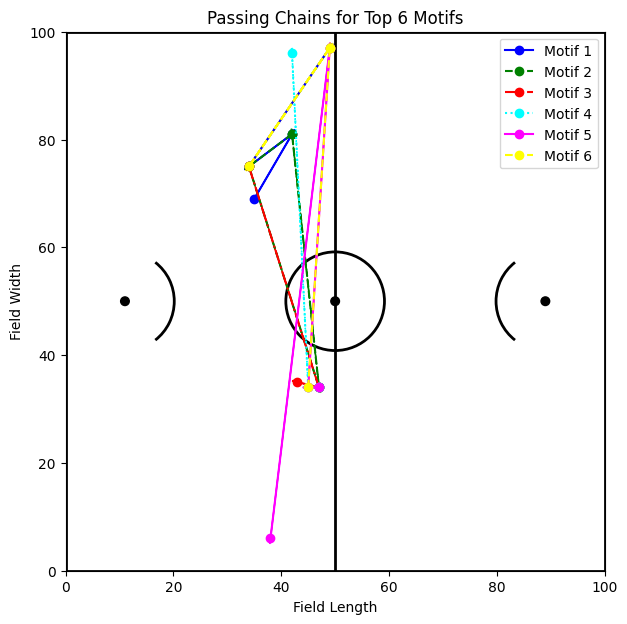

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arc

passes = pass_data_all[['matchId', 'minute', 'second', 'player.id', 'pass.recipient.id', 'team.id', 'pass.endLocation.x', 'pass.endLocation.y']]

passes = passes.sort_values(by=['matchId', 'minute', 'second']).reset_index(drop=True)

def find_passing_motifs(passes, motif_length=3):
    motifs = []
    match_ids = passes['matchId'].unique()
    
    for match_id in match_ids:
        match_passes = passes[passes['matchId'] == match_id]
        
        for i in range(len(match_passes) - motif_length + 1):
            motif = match_passes.iloc[i:i+motif_length]
            motif_players = motif['player.id'].tolist()
            motif_recipient = motif['pass.recipient.id'].tolist()

            if len(set(motif['team.id'])) == 1 and len(set(motif_recipient[:-1])) == motif_length - 1:
                motifs.append({
                    'matchId': match_id,
                    'motif': motif_players + [motif_recipient[-1]],
                    'start_time': motif.iloc[0]['minute'] * 60 + motif.iloc[0]['second'],
                    'end_time': motif.iloc[-1]['minute'] * 60 + motif.iloc[-1]['second'],
                    'team_id': motif.iloc[0]['team.id']
                })
    
    return motifs

sample_passes = passes.sample(frac=0.1, random_state=42)

passing_motifs = find_passing_motifs(sample_passes)

motifs_df = pd.DataFrame(passing_motifs)

def get_pass_end_locations(row):
    end_locations_x = []
    end_locations_y = []
    for pid in row['motif']:
        try:
            end_location_x = pass_data_all.loc[(pass_data_all['matchId'] == row['matchId']) & (pass_data_all['player.id'] == pid), 'pass.endLocation.x'].values[0]
            end_location_y = pass_data_all.loc[(pass_data_all['matchId'] == row['matchId']) & (pass_data_all['player.id'] == pid), 'pass.endLocation.y'].values[0]
            end_locations_x.append(end_location_x)
            end_locations_y.append(end_location_y)
        except IndexError:
            pass
    return end_locations_x, end_locations_y

motifs_df['pass_end_locations'] = motifs_df.apply(get_pass_end_locations, axis=1)
motifs_df['pass_end_x'] = motifs_df['pass_end_locations'].apply(lambda loc: loc[0])
motifs_df['pass_end_y'] = motifs_df['pass_end_locations'].apply(lambda loc: loc[1])

# field
def draw_pitch(ax=None, color='black', lw=2):
    if ax is None:
        ax = plt.gca()
    
    # Pitch Outline & Centre Line
    ax.plot([0, 0, 100, 100, 0], [0, 100, 100, 0, 0], color=color, lw=lw)
    ax.plot([50, 50], [0, 100], color=color, lw=lw)
    

    
    # Prepare Circles; 10 yard circle at centre and 1 yard circle at each penalty spot
    centreCircle = plt.Circle((50, 50), 9.15, color=color, fill=False, lw=lw)
    centreSpot = plt.Circle((50, 50), 0.8, color=color, fill=True)
    leftPenSpot = plt.Circle((11,50), 0.8, color=color, fill=True)
    rightPenSpot = plt.Circle((89,50), 0.8, color=color, fill=True)
    
    # Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)
    
    # Draw Arcs
    leftArc = Arc((11, 50), height=18.3, width=18.3, angle=0, theta1=308, theta2=52, color=color, lw=lw)
    rightArc = Arc((89, 50), height=18.3, width=18.3, angle=0, theta1=128, theta2=232, color=color, lw=lw)
    
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
    return ax


colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']
linestyles = ['-', '--', '-.', ':', '-', '--']


plt.figure(figsize=(10, 7))
ax = draw_pitch()
for index, (color, linestyle) in enumerate(zip(colors, linestyles)):
    if index >= 6:
        break
    row = motifs_df.iloc[index]
    plt.plot(row['pass_end_x'], row['pass_end_y'], marker='o', color=color, linestyle=linestyle, label=f'Motif {index+1}')
    for i in range(len(row['pass_end_x']) - 1):
        plt.arrow(row['pass_end_x'][i], row['pass_end_y'][i], row['pass_end_x'][i+1] - row['pass_end_x'][i], row['pass_end_y'][i+1] - row['pass_end_y'][i], head_width=1, head_length=1, fc=color, ec=color, linestyle=linestyle)
plt.title('Passing Chains for Top 6 Motifs')
plt.xlabel('Field Length')
plt.ylabel('Field Width')
plt.legend()
plt.xlim(0, 100)  
plt.ylim(0, 100)  
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

